# trimming and log, normalization

We are going to use the first derivative method for trimming. The D1 profile reflects the abrupt changes in pitch values and we can set a threshold beyond which the pitch values are deemed as spuriously too high. 

That threshold is 1.6 currently (this works on normalized space with mean of 0 and std of 1).

One discovery we had is that the simple log transformation (like that of Surendran) actually doesn't preserve the relationships between pitch contours well. The log space is not behaving in the same way as the Hertz space. Here is an example of using simple log vs. using Bark scale, which is more linear in lower values and log in higher values.

## contrast between log and Bark scale: case study

### Log scale

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

def read_tab(inputfile):
    
    f=open(inputfile,'r').read().split('\n')

    time=[]
    pitch=[]
    for i in range(1,len(f)):
        line=f[i]
        if line!="":
            split=line.split('\t')
            #print split
            time.append(float(split[0]))
            pitch.append(float(split[1]))
    
    plt.plot(pitch,'gx')
    return time,pitch

def read_tab_only(inputfile):
    
    f=open(inputfile,'r').read().split('\n')

    time=[]
    pitch=[]
    for i in range(1,len(f)):
        line=f[i]
        if line!="":
            split=line.split('\t')
            #print split
            time.append(float(split[0]))
            pitch.append(float(split[1]))
    
    #plt.plot(pitch,'gx')
    return time,pitch

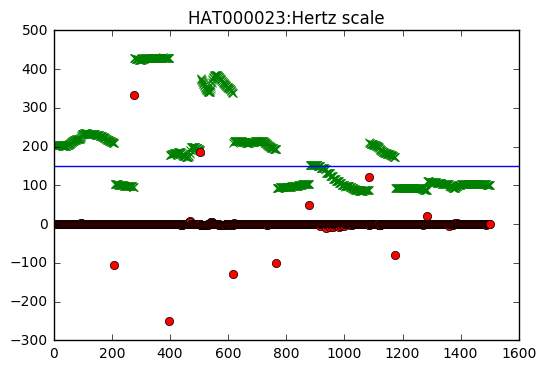

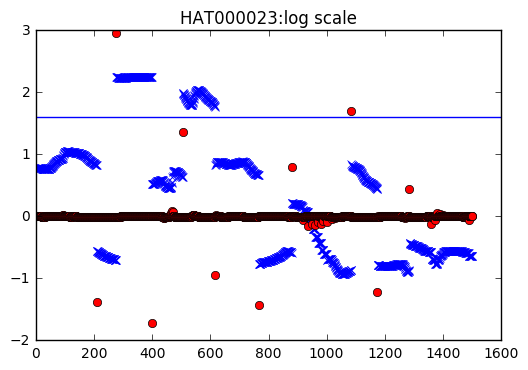

In [22]:
pickle_file='spk_mean_dict.p'
spk_mean_dict=pickle.load(open(pickle_file,'rb'))

#hertz scale
inputfile='pitch/pitcHAT000023.tab'
time,pitch=read_tab(inputfile)
der=[]
for i in range(len(time)-1):
    d1=(pitch[i+1]-pitch[i])
    der.append(d1)

plt.plot(der,'ro')
plt.axhline(y=150)
plt.title('HAT000023:Hertz scale')

#log scale
plt.figure()
spk_mean=spk_mean_dict['HAT']
pitch_norm=(np.log2(pitch)-np.log2(spk_mean))/np.std(np.log2(pitch))
plt.plot(pitch_norm,'bx')
der=[]
for i in range(len(pitch_norm)-1):
    d1=(pitch_norm[i+1]-pitch_norm[i])
    der.append(d1)

plt.plot(der,'ro')
plt.title('HAT000023:log scale')
plt.axhline(y=1.6)

in the above hertz and log scale you can see that the between the two plots the two points (out of three) near the blue horizontal line are reversed. In original scale the first one is higher than the second one, which will allow us to correctly filter out that segment as a spurious segment. The logged scale failed to do so.

### Bark scale

http://www.fon.hum.uva.nl/praat/manual/BarkSpectrogram.html

spk mean: 138.15441938
275 332.165985757
275 3.18660625793
504 186.849789127
504 1.77970795794
1084 121.715472203
1084 1.23251210449


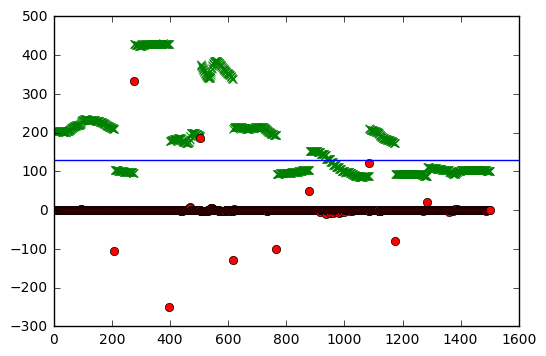

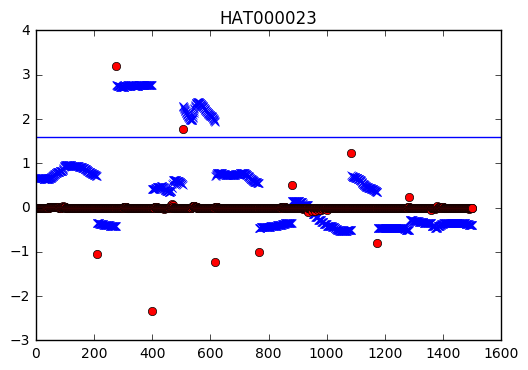

In [52]:

def hertz_to_bark(pitch):
    return 7.0 * np.log (pitch/650.0 + np.sqrt (1 + (pitch/650.0)**2))


inputfile='pitch/pitcHAT000023.tab'
#inputfile='pitch/pitcHAT000100.tab'
#first and second plots
time,pitch=read_tab(inputfile)

der=[]
for i in range(len(time)-1):
    
    d1=(pitch[i+1]-pitch[i])
    der.append(d1)
plt.plot(der,'ro')
plt.axhline(y=130)


#third plot
plt.figure()
spk_mean=spk_mean_dict['HAT']
print 'spk mean:',spk_mean
pitch_bark=hertz_to_bark(np.array(pitch))
pitch_norm=(pitch_bark-hertz_to_bark(spk_mean))/np.std(pitch_bark)
plt.plot(pitch_norm,'bx')
der=[]
for i in range(len(pitch_norm)-1):
    d1=(pitch_norm[i+1]-pitch_norm[i])
    d=pitch[i+1]-pitch[i]
    if d>100:
        print i,d
    der.append(d1)
    if d1>1:
        print i,d1

plt.plot(der,'ro')
plt.title('HAT000023')
plt.axhline(y=1.6)

In this bark scale, in contrast, things are consistent with original and works correctly.

Overall, pitch values 1.6 or above std from the mean is considered spurious.

## sanity check

Let's check this method on more randomly selected pitch contours.

In [55]:
T=130

In [70]:
def sanity_check(inputfile,spk):
    time,pitch=read_tab(inputfile)

    der=[]
    for i in range(len(time)-1):

        d1=(pitch[i+1]-pitch[i])
        der.append(d1)
    plt.plot(der,'ro')
    plt.axhline(y=T)
    plt.axhline(y=-T)


    #third plot
    plt.figure()
    spk_mean=spk_mean_dict[spk]
    print 'spk mean:',spk_mean
    pitch_bark=hertz_to_bark(np.array(pitch))
    pitch_norm=(pitch_bark-hertz_to_bark(spk_mean))/np.std(pitch_bark)
    plt.plot(pitch_norm,'bx')
    der=[]
    for i in range(len(pitch_norm)-1):
        d1=(pitch_norm[i+1]-pitch_norm[i])
        d=pitch[i+1]-pitch[i]
        if d>100:
            print i,d
        der.append(d1)
        if d1>1:
            print i,d1

    plt.plot(der,'ro')
    title=inputfile.split('/')[1]
    plt.title(title)
    plt.axhline(y=1.6)
    

spk mean: 125.402875196


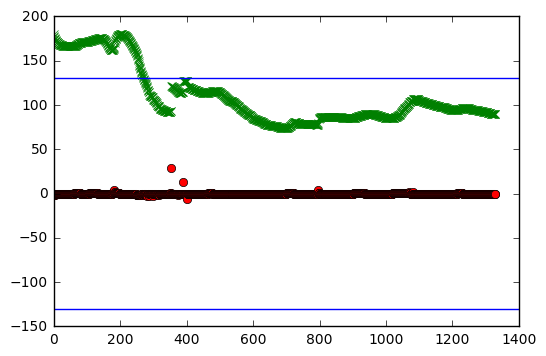

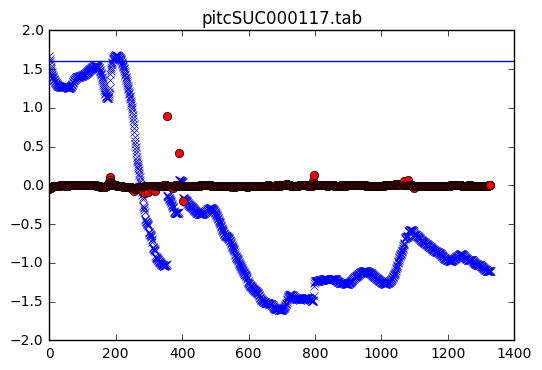

In [71]:
inputfile='pitch/pitcSUC000117.tab'
sanity_check(inputfile,'SUC')

spk mean: 122.842062388
134 268.944063486
134 2.0942131568
311 281.757737538
311 2.18192126117


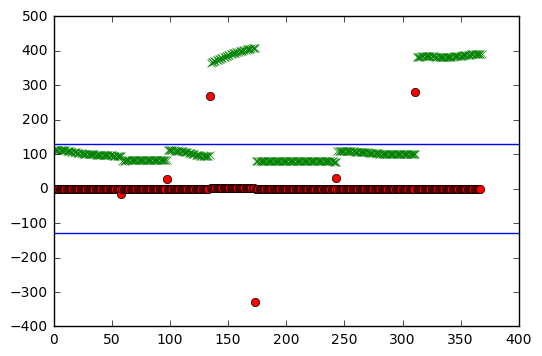

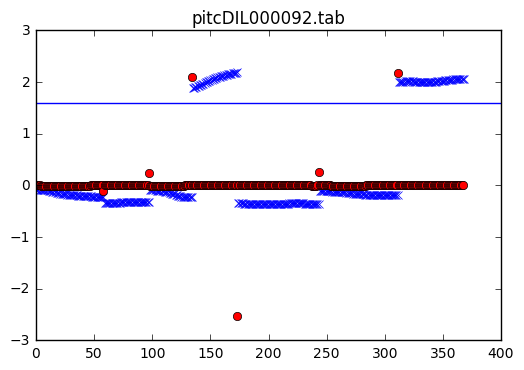

In [72]:
inputfile='pitch/pitcDIL000092.tab'
sanity_check(inputfile,"DIL")

spk mean: 122.842062388
1389 1.23097534907


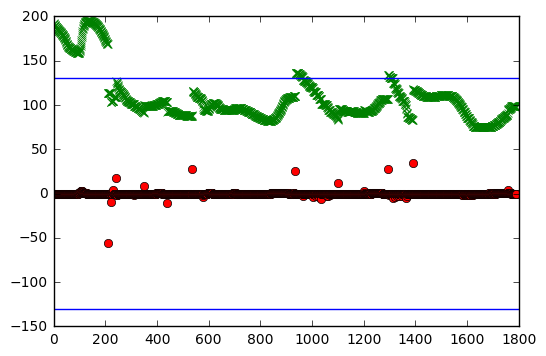

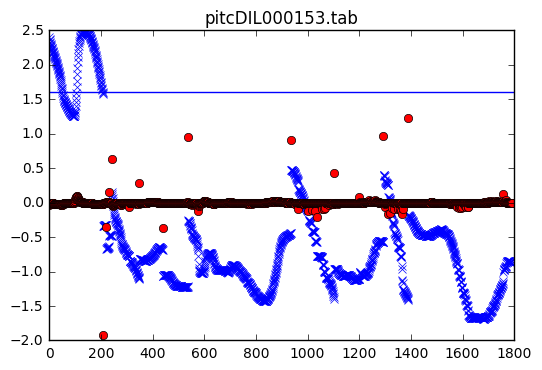

In [73]:
inputfile='pitch/pitcDIL000153.tab'
sanity_check(inputfile,"DIL")

spk mean: 138.15441938
673 192.590212868
673 2.44943247048


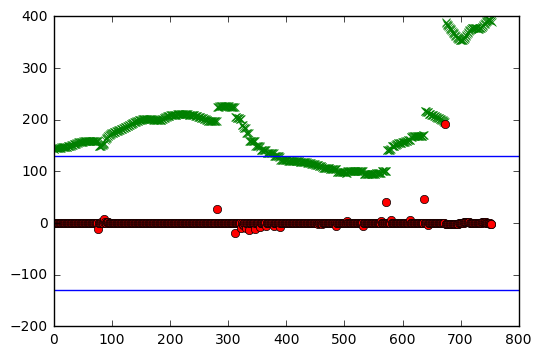

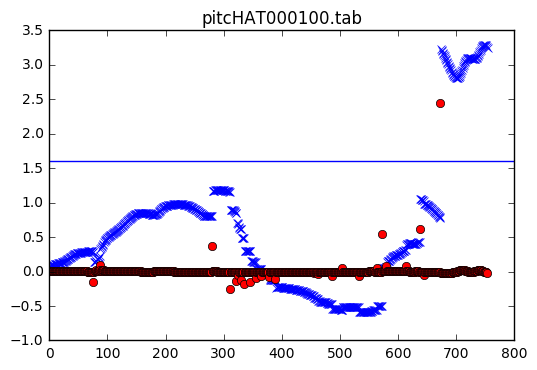

In [74]:
inputfile='pitch/pitcHAT000100.tab'
sanity_check(inputfile,"HAT")

spk mean: 138.15441938
608 503.618346957
608 4.70783219549
2184 377.42207665
2184 3.63700602683
2476 293.238991774
2476 2.90469742759


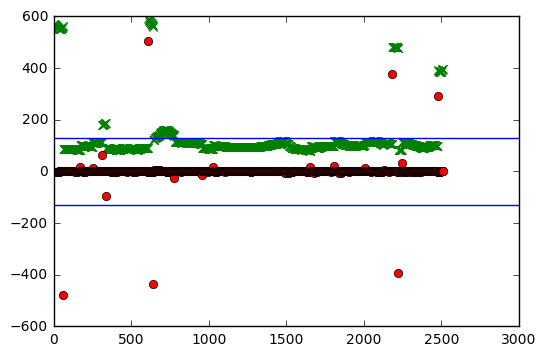

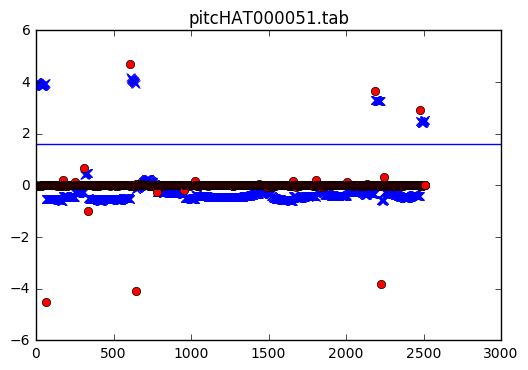

In [75]:
inputfile='pitch/pitcHAT000051.tab'
sanity_check(inputfile,"HAT")

spk mean: 122.842062388
432 1.05524785186
529 2.8918193102


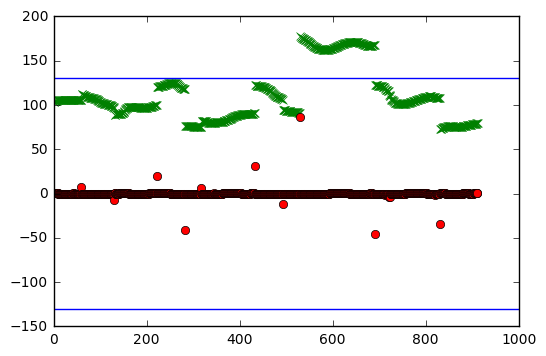

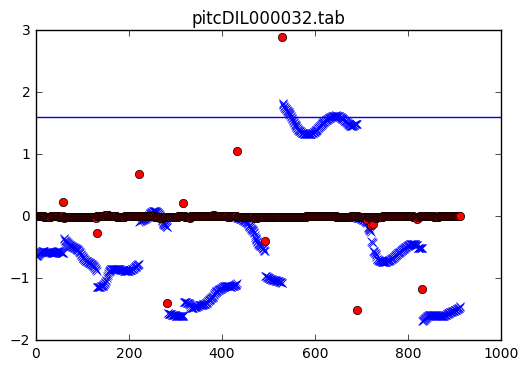

In [76]:
inputfile='pitch/pitcDIL000032.tab'
sanity_check(inputfile,"DIL")

IN this above case, it shows that the original space works well again and even bark space didn't work well in this case, due to scaling too.(that shouldn't be a spurious segment.) This is shown again in the next example.

spk mean: 122.842062388
307 1.2233831542
524 2.00331764406
802 1.08973216815
878 1.08328653804


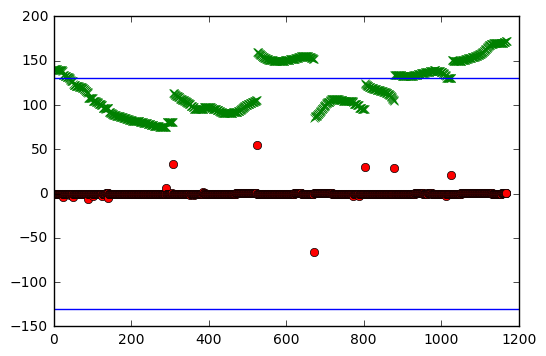

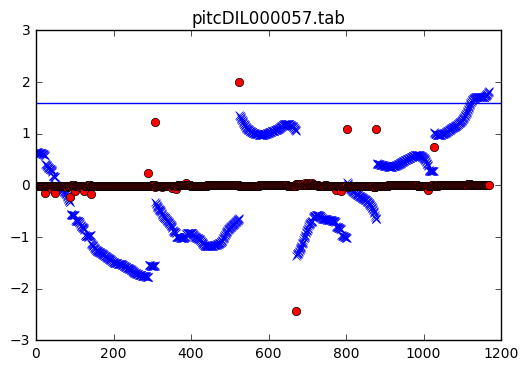

In [77]:
inputfile='pitch/pitcDIL000057.tab'
sanity_check(inputfile,"DIL")

spk mean: 122.842062388
779 304.31362515
779 5.39759693575


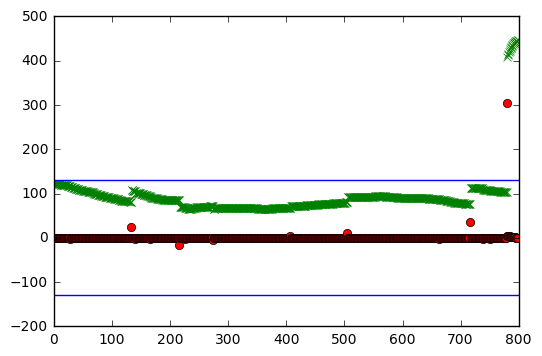

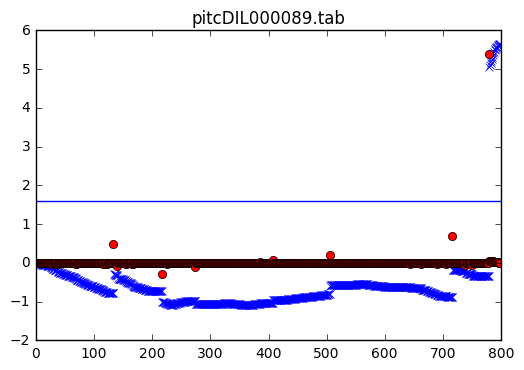

In [78]:
inputfile='pitch/pitcDIL000089.tab'
sanity_check(inputfile,"DIL")

spk mean: 122.842062388
625 2.06887917378
715 1.91854197903


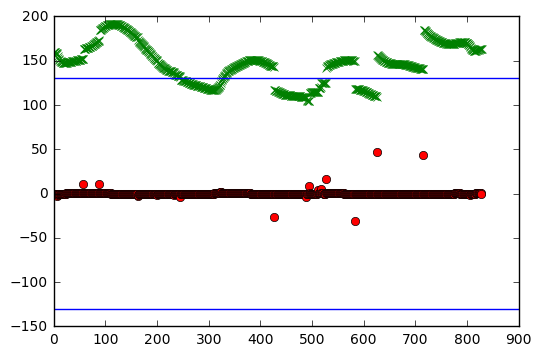

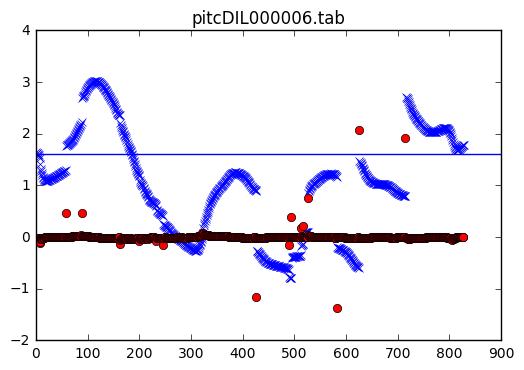

In [79]:
inputfile='pitch/pitcDIL000006.tab'
sanity_check(inputfile,"DIL")

spk mean: 125.402875196
402 2.27887220026
796 1.14027743223
910 1.06406196657


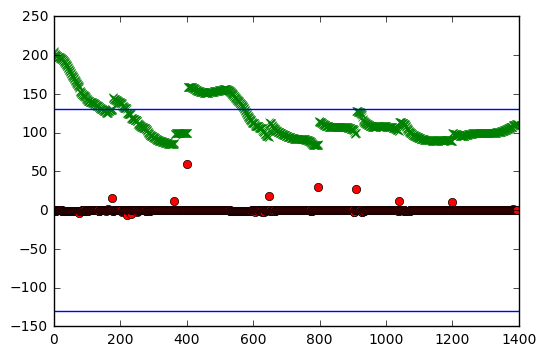

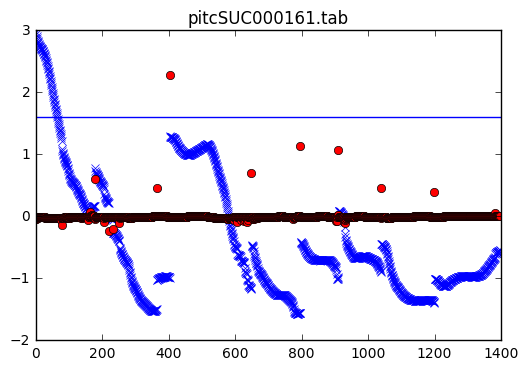

In [80]:
inputfile='pitch/pitcSUC000161.tab'
sanity_check(inputfile,"SUC")

# Conclusion

There is no doubt that the original works the best in filtering spurious pitch values. It is possible as I showed in my earlier works that Bark scale may be superior at clustering (but not classification). It's just different with various tasks.


# Implementation: segmentation, filtering

Use CHJ121 as an example:

spk mean: 156.757063336
185 211.793334954
185 2.04099574517
285 241.347553787
285 2.17750888521
683 455.379004947
683 4.14583788585
740 106.712749069
1598 126.040284761
1598 1.24855747747


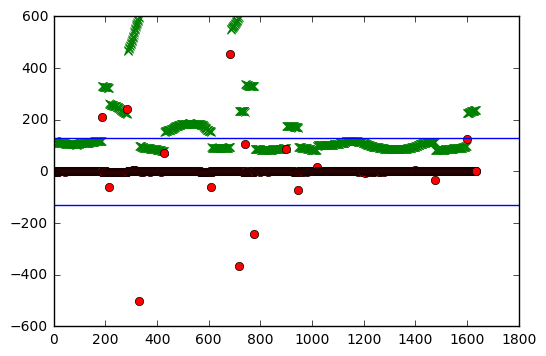

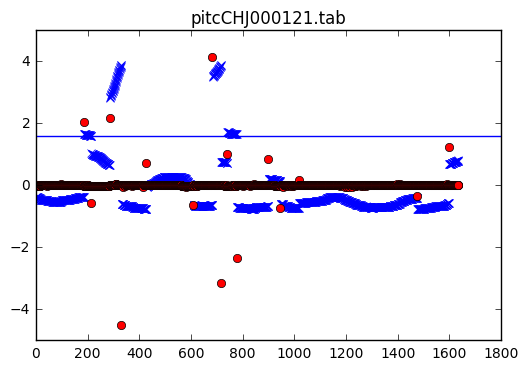

In [81]:
inputfile='pitch/pitcCHJ000121.tab'
sanity_check(inputfile,"CHJ")

In [144]:
#DIVIDE THE PITCH PROFILE INTO SEGMENTS
#FOR EACH SEGMENT, SEE IF ITS BEGINNING AND ENDING PITCH ARE OUTSIDE OF THE BELT.

inputfile='pitch/pitcCHJ000121.tab'
time,pitch=read_tab_only(inputfile)
segments_time=[[0]]
segments_pitch=[[0]]
begin=0
for i in range(1,len(time)):
    if time[i]-time[i-1]>0.0012:
        segments_pitch.append(pitch[begin:i-1])
        segments_time.append(time[begin:i-1])
        begin=i
        #print i
#print i
segments_time.append(time[begin:])
segments_pitch.append(pitch[begin:])
#print len(segments_time)


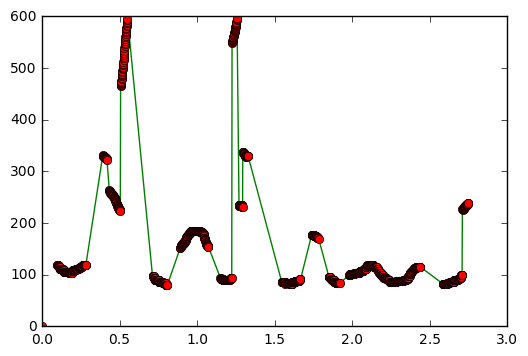

In [145]:
plt.plot(time,pitch,'g-')
for i in range(len(segments_time)):
    plt.plot(segments_time[i],segments_pitch[i],'ro')
#plt.plot(segments_time[-2],segments_pitch[-2],'gx')
#plt.plot(time[1600:],pitch[1600:],'bx')

In [164]:
len(segments_pitch)

16

In [166]:
filtered_segments_time=[]
filtered_segments_pitch=[]
spk_mean=spk_mean_dict['CHJ']
for i in range(1,len(segments_pitch)):
    beginning_d1=segments_pitch[i][0]-segments_pitch[i-1][-1]
    if i<len(segments_pitch)-1:
        ending_d1=segments_pitch[i+1][-0]-segments_pitch[i][-1]
        if not (np.abs(beginning_d1)>T and np.abs(ending_d1)>T):
            filtered_segments_time.append(segments_time[i])
            filtered_segments_pitch.append(segments_pitch[i])
    elif i==(len(segments_pitch)-1):
        if not np.abs(beginning_d1)>T:
            filtered_segments_time.append(segments_time[i])
            filtered_segments_pitch.append(segments_pitch[i])


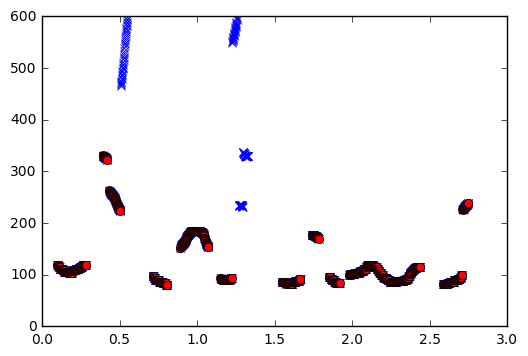

In [168]:
plt.plot(time,pitch,'x')

for i in range(len(filtered_segments_pitch)):
    plt.plot(filtered_segments_time[i],filtered_segments_pitch[i],'ro')


in this case, if we still want to get rid of the beginning two segments, then we need the value based filtering

### formalize this

In [193]:
# build segments
def filter(inputfile,speaker):
    spk_mean=spk_mean_dict[speaker]
    time,pitch=read_tab_only(inputfile)
    segments_time=[[0]]
    segments_pitch=[[spk_mean]]
    begin=0
    for i in range(1,len(time)):
        if time[i]-time[i-1]>0.0012:
            segments_pitch.append(pitch[begin:i-1])
            segments_time.append(time[begin:i-1])
            begin=i
            #print i
    #print i
    segments_time.append(time[begin:])
    segments_pitch.append(pitch[begin:])
    #print len(segments_time)

    #check if it segmented right
    plt.plot(time,pitch,'g-')
    for i in range(len(segments_time)):
        plt.plot(segments_time[i],segments_pitch[i],'ro')

    #filter
    filtered_segments_time=[]
    filtered_segments_pitch=[]
    
    for i in range(1,len(segments_pitch)):
        beginning_d1=segments_pitch[i][0]-segments_pitch[i-1][-1]
        if i<len(segments_pitch)-1:
            ending_d1=segments_pitch[i+1][-0]-segments_pitch[i][-1]
            if not (np.abs(beginning_d1)>T and np.abs(ending_d1)>T):
                filtered_segments_time.append(segments_time[i])
                filtered_segments_pitch.append(segments_pitch[i])
        elif i==(len(segments_pitch)-1):
            if not np.abs(beginning_d1)>T:
                filtered_segments_time.append(segments_time[i])
                filtered_segments_pitch.append(segments_pitch[i])


    #check filter results
    plt.figure()
    plt.plot(time,pitch,'x')

    for i in range(len(filtered_segments_pitch)):
        plt.plot(filtered_segments_time[i],filtered_segments_pitch[i],'ro')


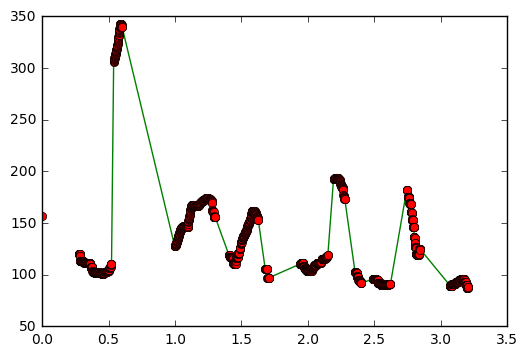

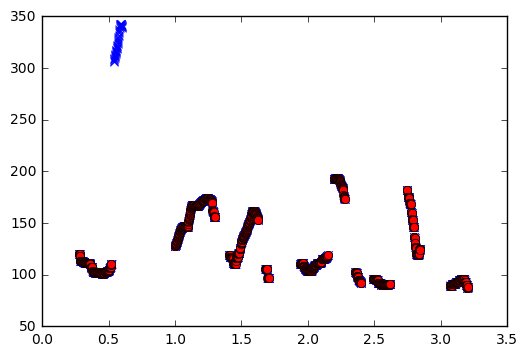

In [194]:
inputfile='pitch/pitcCHJ000056.tab'
filter(inputfile,"CHJ")

<hr>

spk mean: 156.757063336
246 195.402964473
246 3.87916479107
1081 1.49920507777
1346 1.85614643486


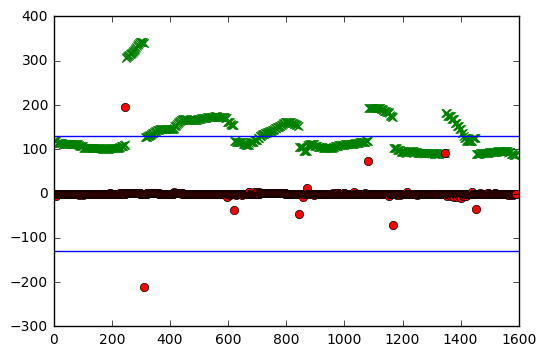

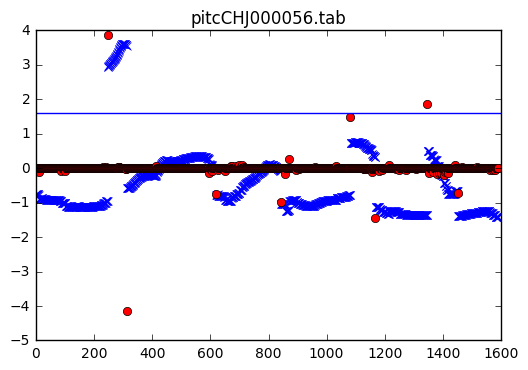

In [185]:
inputfile='pitch/pitcCHJ000056.tab'
sanity_check(inputfile,"CHJ")

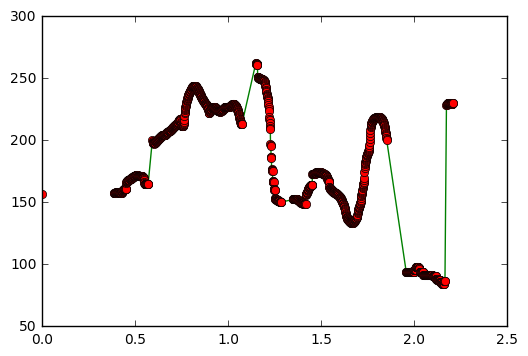

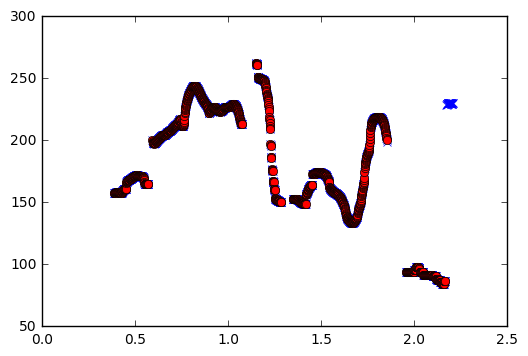

In [195]:
inputfile='pitch/pitcCHJ000126.tab'
filter(inputfile,"CHJ")

spk mean: 156.757063336
665 1.00640431728
1517 141.9925851
1517 3.02851930446


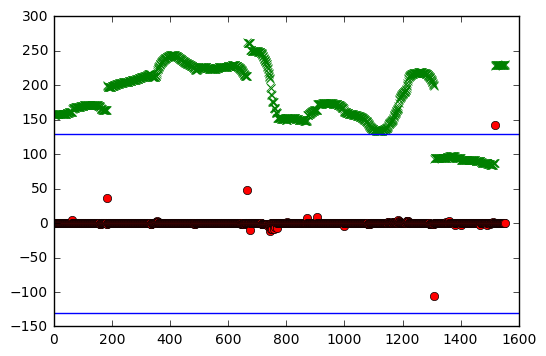

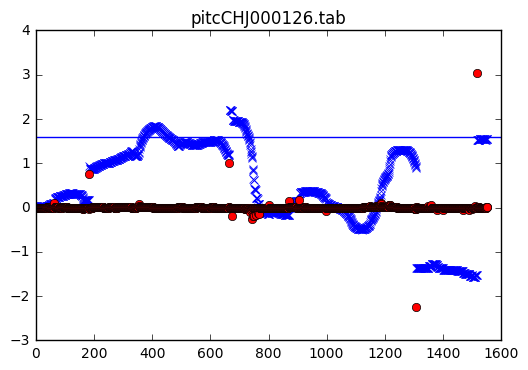

In [187]:
inputfile='pitch/pitcCHJ000126.tab'
sanity_check(inputfile,"CHJ")

spk mean: 200.248731719
53 132.456262375
53 1.2146732812
303 412.494702864
303 3.41348976025


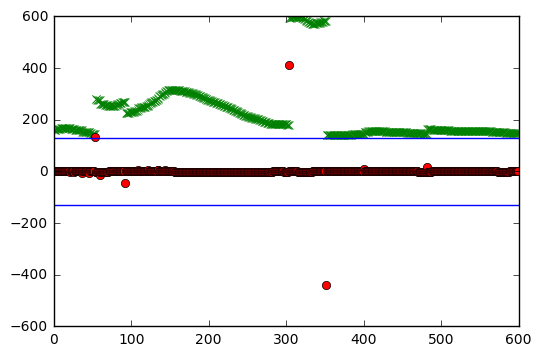

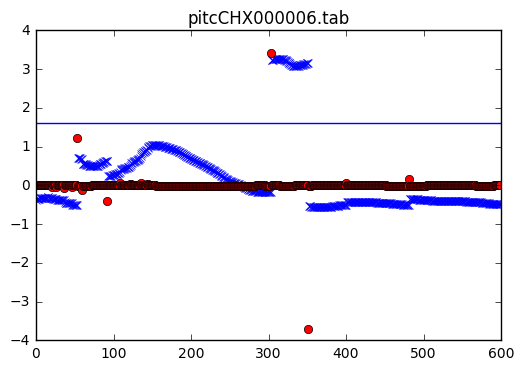

In [84]:
inputfile='pitch/pitcCHX000006.tab'
sanity_check(inputfile,"CHX")

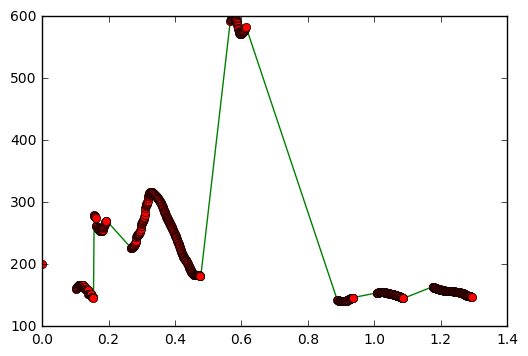

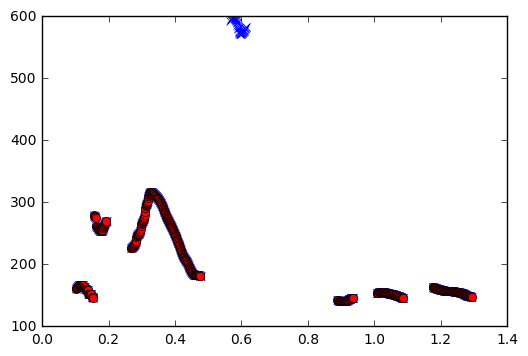

In [196]:
inputfile='pitch/pitcCHX000006.tab'
filter(inputfile,'CHX')

spk mean: 200.248731719


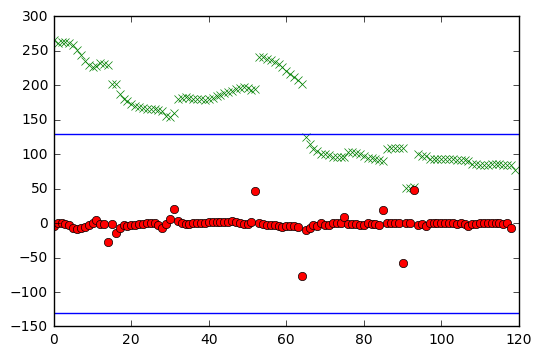

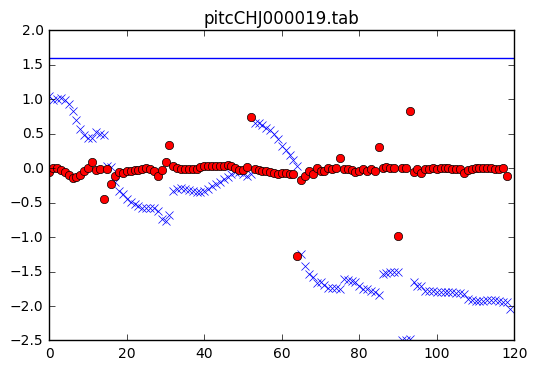

In [207]:
inputfile='pitch/pitcCHJ000019.tab'
sanity_check(inputfile,"CHX")

spk mean: 200.248731719
362 386.616612313
362 6.8144694215
1014 1.10723728343
2085 1.68332747694


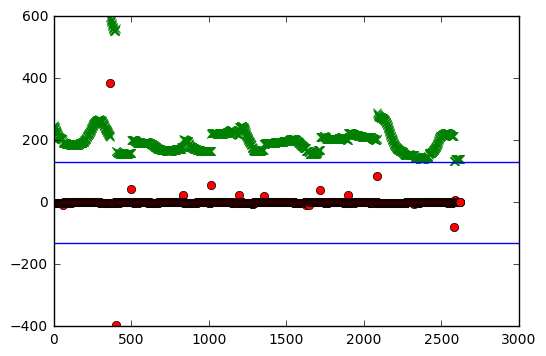

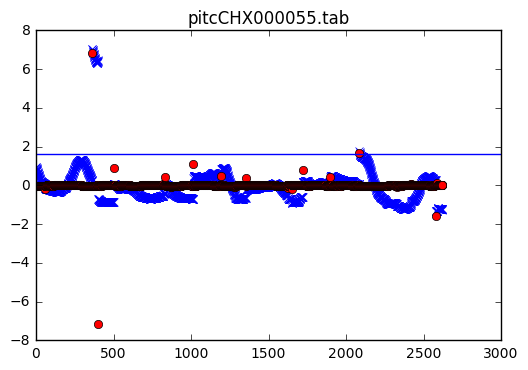

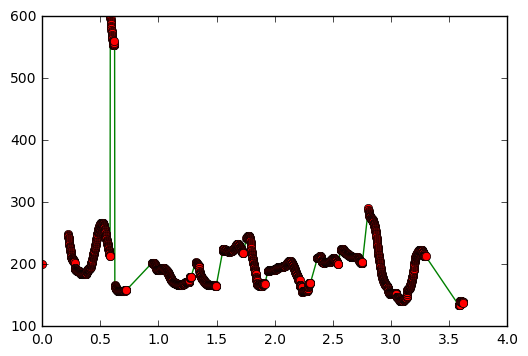

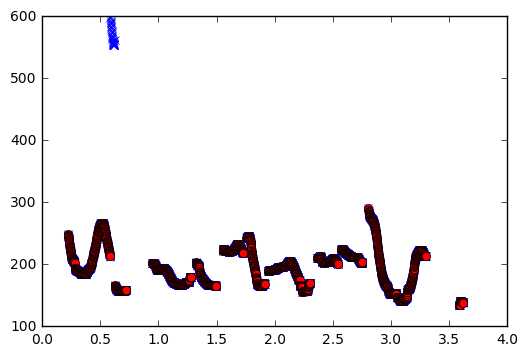

In [197]:
inputfile='pitch/pitcCHX000055.tab'
sanity_check(inputfile,"CHX")
plt.figure()
filter(inputfile,'CHX')

In [198]:
def trim(inputfile,speaker):
    pickle_file='spk_mean_dict.p'
    spk_mean_dict=pickle.load(open(pickle_file,'rb'))

    spk_mean=spk_mean_dict[speaker]
    time,pitch=read_tab_only(inputfile)
    segments_time=[[0]]
    segments_pitch=[[spk_mean]]
    begin=0
    for i in range(1,len(time)):
        if time[i]-time[i-1]>0.0012:
            segments_pitch.append(pitch[begin:i-1])
            segments_time.append(time[begin:i-1])
            begin=i
            #print i
    #print i
    segments_time.append(time[begin:])
    segments_pitch.append(pitch[begin:])
    #print len(segments_time)

    #filter
    filtered_segments_time=[]
    filtered_segments_pitch=[]
    
    for i in range(1,len(segments_pitch)):
        beginning_d1=segments_pitch[i][0]-segments_pitch[i-1][-1]
        if i<len(segments_pitch)-1:
            ending_d1=segments_pitch[i+1][-0]-segments_pitch[i][-1]
            if not (np.abs(beginning_d1)>T and np.abs(ending_d1)>T):
                filtered_segments_time.append(segments_time[i])
                filtered_segments_pitch.append(segments_pitch[i])
        elif i==(len(segments_pitch)-1):
            if not np.abs(beginning_d1)>T:
                filtered_segments_time.append(segments_time[i])
                filtered_segments_pitch.append(segments_pitch[i])
    total_filtered_time=[]
    total_filtered_pitch=[]
    for i in range(len(filtered_segments_pitch)):
        total_filtered_time.extend(filtered_segments_time[i])
        total_filtered_pitch.extend(filtered_segments_pitch[i])
    return time,total_filtered_time,pitch,total_filtered_pitch

In [201]:
a,b,c,d=trim(inputfile,"CHX")

In [204]:
print len(a),len(b),len(c),len(d)

2622 2574 2622 2574


In [205]:
print d

[248.75855641259596, 247.72657625086734, 246.68448221634995, 245.6189275820445, 244.50568991260758, 243.31108814395756, 242.00670730318222, 240.59070911329786, 239.10634142752662, 237.57107529074054, 235.91780590978192, 234.08648635934972, 232.3534167471105, 230.98549861681272, 229.87715768218658, 228.9030573669481, 227.9754302583535, 227.0271900724325, 225.99056935548458, 224.809592952443, 223.50865125677294, 222.19696924879602, 220.910698654073, 219.60439090537542, 218.30787667367667, 217.1088486196744, 215.98502613404793, 214.81304352248816, 213.4857006013753, 212.28938288540243, 211.45366720925327, 210.84095204285774, 210.34920480822666, 209.93160042259757, 209.56175461533198, 209.22501935870562, 208.91207083522832, 208.6162115848669, 208.3325663181561, 208.05722683669623, 207.78668865162973, 207.5201123490897, 207.25461534950986, 206.9887599125996, 206.72152751761993, 206.45243152839942, 206.18108621639706, 205.90675492891796, 205.62882095111442, 205.34679081570633, 205.0594504552

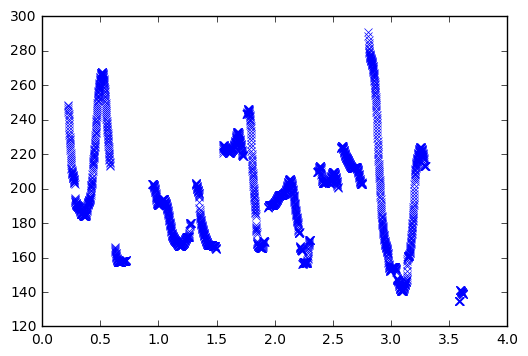

In [206]:
plt.plot(b,d,'x')

In [214]:
inputfile='pitch/pitcFAJ000461.tab'

72
456


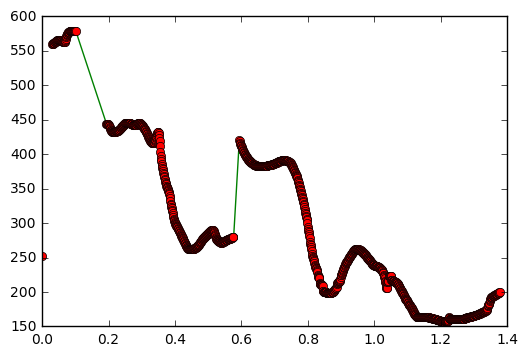

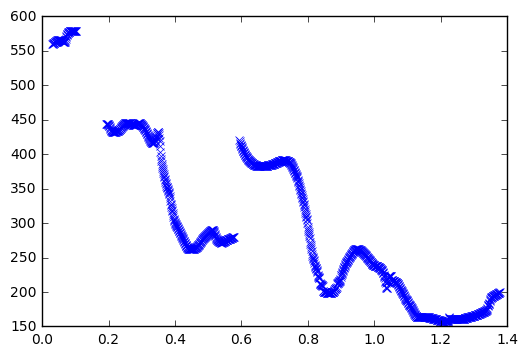

In [215]:
speaker="FAJ"
spk_mean=spk_mean_dict[speaker]
time,pitch=read_tab_only(inputfile)
segments_time=[[0]]
segments_pitch=[[spk_mean]]
begin=0
for i in range(1,len(time)):
    if time[i]-time[i-1]>0.0012:
        print i
        segments_pitch.append(pitch[begin:i-1])
        segments_time.append(time[begin:i-1])
        begin=i
        #print i
#print i
segments_time.append(time[begin:])
segments_pitch.append(pitch[begin:])
#print len(segments_time)

#check if it segmented right
plt.plot(time,pitch,'g-')
for i in range(len(segments_time)):
    plt.plot(segments_time[i],segments_pitch[i],'ro')

#filter
filtered_segments_time=[]
filtered_segments_pitch=[]

for i in range(1,len(segments_pitch)):
    beginning_d1=segments_pitch[i][0]-segments_pitch[i-1][-1]
    if i<len(segments_pitch)-1:
        ending_d1=segments_pitch[i+1][-0]-segments_pitch[i][-1]
        if not (np.abs(beginning_d1)>T and np.abs(ending_d1)>T):
            filtered_segments_time.append(segments_time[i])
            filtered_segments_pitch.append(segments_pitch[i])
    elif i==(len(segments_pitch)-1):
        if not np.abs(beginning_d1)>T:
            filtered_segments_time.append(segments_time[i])
            filtered_segments_pitch.append(segments_pitch[i])


#check filter results
plt.figure()
plt.plot(time,pitch,'x')

for i in range(len(filtered_segments_pitch)):
    plt.plot(filtered_segments_time[i],filtered_segments_pitch[i],'ro')


In [216]:
print len(filtered_segments_time)
print len(filtered_segments_pitch)

0
0


In [217]:
spk_mean_dict['FAJ']

251.68034980825323

In [218]:
len(segments_time)

4

In [219]:
pickle_file_ap='all_pitch_dict.p'
all_pitch_dict=pickle.load(open(pickle_file_ap,'rb'))

KeyboardInterrupt: 